Notebook to generate images of stratification profiles for Sandhya.

In [1]:
import matplotlib.pyplot as plt
import datetime
import numpy as np
import netCDF4 as nc
import seaborn as sns

from salishsea_tools import viz_tools

import comparisons
import ONC_patrols as onc

%matplotlib inline

/home/nsoontie/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
sns.set_color_codes()
sns.set_context('paper')
sns.set_style('whitegrid')

In [3]:
bad_QC = [0,3,4,9]

In [4]:
csvfile = '/ocean/nsoontie/MEOPAR/ONC/Patrols/Steveston_Patrol8_CTD_20150525T171143Z_20151005T222329Z-Corrected.csv'

data = onc.load_patrol_csv(csvfile)
data = onc.exclude_bad(data,['Practical Salinity Corrected QC Flag  '], bad_QC)
data = onc.divide_into_casts(data)

In [5]:
data.columns

Index(['time', 'Absolute Pressure Corrected (decibar)',
       'Absolute Pressure Corrected QC Flag  ', 'Conductivity Corrected (S/m)',
       'Conductivity Corrected QC Flag  ', 'Density Corrected (kg/m3)',
       'Density Corrected QC Flag  ', 'Depth Corrected (m)',
       'Depth Corrected QC Flag  ', 'Practical Salinity Corrected (psu)',
       'Practical Salinity Corrected QC Flag  ',
       'Pressure Corrected (decibar)', 'Pressure Corrected QC Flag  ',
       'Sound Speed Corrected (m/s)', 'Sound Speed Corrected QC Flag  ',
       'Temperature Corrected (C)', 'Temperature Corrected QC Flag  ',
       'Latitude Corrected (deg)', 'Latitude Corrected QC Flag  ',
       'Longitude Corrected (deg)', 'Longitude Corrected QC Flag  ', 'day',
       'Cast'],
      dtype='object')

In [6]:
depth_all = np.linspace(0.5,150.5)

(1000, 1025)

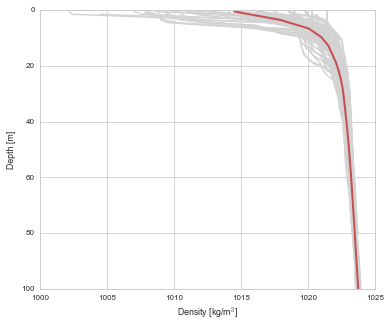

In [7]:
figd, axd = plt.subplots(1,1,figsize=(6,5))

data_casts = data.groupby('Cast')
density_alls = np.zeros((len(data_casts.groups),depth_all.shape[0]))

for i,c in enumerate(data_casts.groups):
    cast = data_casts.get_group(c)
    density = np.array(cast['Density Corrected (kg/m3)'])
    depth = np.array(cast['Depth Corrected (m)'])
    
    density_alls[i,:] = comparisons.interpolate_depth(density, depth, depth_all)
    
    axd.plot(density, depth,'lightgray')
    
density_alls = np.ma.masked_values(density_alls,0)
mean = np.nanmean(density_alls,axis=0)

axd.plot(mean, depth_all,'r',lw=2,label='mean')
    
axd.set_ylabel('Depth [m]')
axd.set_ylim([100,0])

axd.set_xlabel('Density [kg/m$^3$]')
axd.set_xlim([1000,1025])

In [8]:
figd.savefig('StraitofGeorgia_density_ONCPatrols_2015.png')

## Spatial and temporal distribution of data

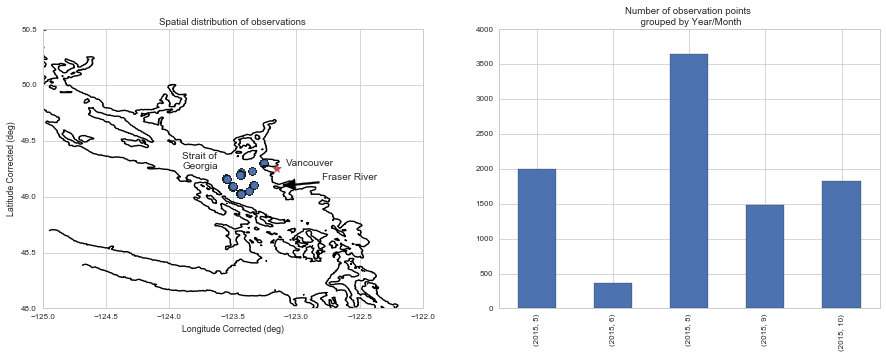

In [9]:
grid_B = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
fig,axs = plt.subplots(1,2,figsize=(15,5))
ax=axs[0]
data.plot(x='Longitude Corrected (deg)', y='Latitude Corrected (deg)',
            kind='scatter',ax=ax,s=50)
viz_tools.plot_coastline(ax,grid_B,coords='map')
ax.set_xlim([-125,-122])
ax.set_ylim([48,50.5])
ax.plot(-123.15,49.25,'r*',ms=10)
ax.text(-123.08,49.28,'Vancouver')
ax.set_title('Spatial distribution of observations')
ax.text(-123.9,49.25,'Strait of\nGeorgia')
ax.annotate('Fraser River',xy=(-123.1,49.1),xytext=(-122.8,49.15),
           arrowprops=dict(facecolor='black',width=2))
    
ax=axs[1]
dday=data['day']
dday.groupby([dday.dt.year, dday.dt.month]).count().plot(kind="bar",ax=ax)
ax.set_title('Number of observation points \n grouped by Year/Month')

## Curve fit

In [10]:
def rho_profile(d, rho0, drho, z0, d0,a,z1,d1):
    return rho0 + drho*np.tanh((d-z0)/d0) +a*d*(1+np.tanh((d-z1)/d1))

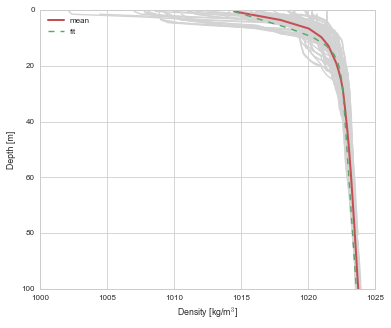

In [11]:
rho0=1016.5
drho=5.7
z0=3.5
d0=8
a=0.007
z1=8
d1=1
axd.plot( rho_profile(depth_all,rho0, drho, z0, d0,a,z1,d1),depth_all, '--g',label='fit')
axd.legend(loc=2)
figd

